In [192]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
# from keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numba

# Data Preprocessing
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from sklearn.model_selection import train_test_split
sys.setrecursionlimit(10000)

print(tf.__version__)

2.11.0


In [193]:
LABELS_PATH = './train/labels.txt'
DATA_PATH = './train/'
img_height = 13
img_width = 13
batch_size = 3

In [194]:
df = pd.read_csv(LABELS_PATH, header=None)
df.columns

Int64Index([0, 1, 2], dtype='int64')

In [195]:
df['file'] = df.index
df['file'] = df['file'].apply(lambda x: str(x)+'.png')

df['labels'] = df[[0, 1, 2]].apply(lambda row: ','.join(row), axis=1)

In [196]:
df.head()

,0,1,2,file,labels
0,ZETA,EPSILON,LAMDA,0.png,"ZETA,EPSILON,LAMDA"
1,DELTA,ALPHA,EPSILON,1.png,"DELTA,ALPHA,EPSILON"
2,RHO,PHI,PI,2.png,"RHO,PHI,PI"
3,TAU,XI,PSI,3.png,"TAU,XI,PSI"
4,PI,OMICRON,IOTA,4.png,"PI,OMICRON,IOTA"


In [197]:
dataset_paths = glob.glob(DATA_PATH + "*.png")

In [198]:
color_threshold = 245

def load_img(path):
    img = cv2.imread(path)
    # print(img.shape)
    HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img, HSV

@numba.njit(cache=True)
def dfs(x, y, img, visited, component_number):
    h, w = img.shape
    if visited[y][x] != 0:
        return
    if y>=h or y<0:
        return
    if x>=w or x<0:
        return
    if img[y][x] < color_threshold:
        return
    visited[y][x] = component_number
    dfs(x+1, y, img, visited, component_number)
    dfs(x, y+1, img, visited, component_number)
    dfs(x-1, y, img, visited, component_number)
    dfs(x, y-1, img, visited, component_number)
    return

def crop(image):
    margin = 10
    y_nonzero, x_nonzero = np.nonzero(image)
    return image[np.min(y_nonzero)-margin:np.max(y_nonzero)+margin, np.min(x_nonzero)-margin:np.max(x_nonzero)+margin]

@numba.njit(cache=True)
def dfs_in_image(img:cv2.Mat):
    h, w = img.shape
    components = []
    component_number = 50
    visited_mat = np.zeros(img.shape)
    for i in range(w):
        for j in range(h):
            if img[j][i] > color_threshold:
                if visited_mat[j][i] == 0:
                    old_component = component_number
                    if np.sum(visited_mat[:, i]) == 0:
                        component_number += 50 # increase only if a new column
                    dfs(i, j, img, visited_mat, component_number)
                    if old_component != component_number:
                        # print("Found Component", component_number)
                        components.append(component_number)

    return visited_mat, components

def filter_letters_from_image(path):
    gaussian_kernel_size = 9
    erosion_kernel_size = 2
    lower_threshold_letter = np.array([0, 125, 255])
    upper_threshold_letter = np.array([255, 129, 255])
    
    img, hsv_img = load_img(path)
    
    mask = cv2.inRange(hsv_img, lower_threshold_letter, upper_threshold_letter)
    # result = cv2.bitwise_and(img, img, mask=mask)

    blurred_mask = cv2.GaussianBlur(mask, (gaussian_kernel_size, gaussian_kernel_size), 0)

    kernel = np.ones((erosion_kernel_size, erosion_kernel_size), np.uint8)
    erosion = cv2.erode(mask, kernel, iterations = 2)

    dilated_mask = cv2.dilate(erosion, kernel,iterations = 1)
    
    return blurred_mask, dilated_mask

def segment_letters(components, segmented):
    letters = []
    for component in components:
        lower = np.array([component-1])
        upper = np.array([component+1])
        mask = cv2.inRange(segmented, lower, upper)
        masked = cv2.bitwise_and(segmented, segmented, mask=mask)
        letters.append(masked)
    return letters

In [199]:
def umbrella_get_letter(letter_loc:tuple, down_points:tuple):
    """Obtain cropped letter of specified file and index

    Args:
        letter_loc (tuple): (file_path, letter_index)

    Returns:
        np.ndarray: Image matrix of cropped letter
    """
    path_, idx = letter_loc
    blurred, dilated = filter_letters_from_image(path_)
    segmented, components = dfs_in_image(dilated)
    letters = segment_letters(components, segmented)
    cropped = crop(letters[idx])
    resized_down = cv2.resize(cropped, down_points, interpolation= cv2.INTER_LINEAR)
    return cropped

def umbrella_get_letters(path_:str):
    """Obtain cropped letter of specified file and index

    Args:
        path_(str): path to file

    Returns:
        list of np.ndarray: Image matrices of cropped letter
    """
    down_points = (img_width, img_height)
    blurred, dilated = filter_letters_from_image(path_)
    segmented, components = dfs_in_image(dilated)
    letters = segment_letters(components, segmented)
    cropped = []
    for letter in letters:
        letter = crop(letter)
        letter = cv2.resize(letter, down_points, interpolation= cv2.INTER_LINEAR) # reshape
        letter = cv2.normalize(letter, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) # normalise
        cropped.append(letter)
    return cropped

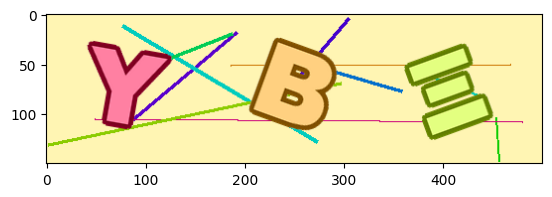

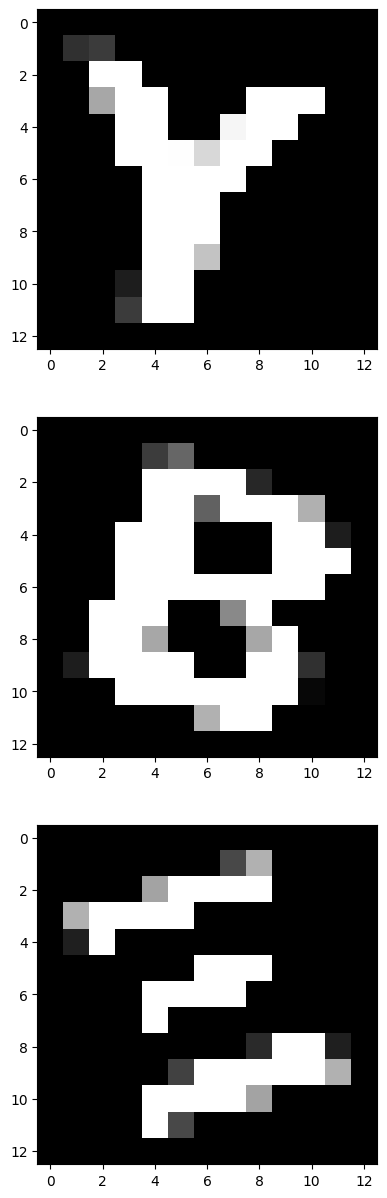

In [218]:
# blurred, dilated = filter_letters_from_image(DATA_PATH + '26.png')
# segmented, components = dfs_in_image(dilated)
# letters = segment_letters(components, segmented)
path_ = DATA_PATH + '300.png'
cropped = umbrella_get_letters(path_)

img, hsv = load_img(path_)
plt.imshow(img)
fig, ax = plt.subplots(len(cropped), 1, figsize=(15, 15))
for i, _ in enumerate(cropped):
    cropped_letter = cropped[i]
    ax[i].imshow(cropped_letter, cmap='gray')

In [201]:
# Create tmp data_set
# !Not used
def create_tmp_dataset():
    max_height = 0
    max_width = 0
    if not os.path.isdir('./tmp'):
        os.mkdir('./tmp')

    class_occurences = {}
    for idx, row in tqdm(df.iterrows()):
        indices = [0, 1, 2]
        for index in indices:
            class_ = row[index]
            meta = (DATA_PATH + row['file'], index)
            if class_ in class_occurences.keys():
                class_occurences[class_] += 1
            else:
                class_occurences[class_] = 0
            letter = umbrella_get_letter(meta)
            if letter.shape[0] > max_height:
                max_height = letter.shape[0]
            if letter.shape[1] > max_width:
                max_width = letter.shape[1]
                
            status = cv2.imwrite(f'./tmp/{class_}_{class_occurences[class_]}_{row["file"][:-4]}.png', letter)
    print(class_occurences), (max_width, max_height)

# Model

In [202]:
classes = os.listdir('./reference/')
classes = [x[:-4] for x in classes]
# len(classes), classes
class_dict = {x: i for i, x in enumerate(classes)}

class_dict

{'OMEGA': 0,
 'NU': 1,
 'OMICRON': 2,
 'CHI': 3,
 'THETA': 4,
 'ZETA': 5,
 'PSI': 6,
 'GAMMA': 7,
 'UPSILON': 8,
 'TAU': 9,
 'MU': 10,
 'SIGMA': 11,
 'DELTA': 12,
 'IOTA': 13,
 'PI': 14,
 'BETA': 15,
 'PHI': 16,
 'ETA': 17,
 'XI': 18,
 'KAPPA': 19,
 'ALPHA': 20,
 'EPSILON': 21,
 'LAMDA': 22,
 'RHO': 23}

In [203]:
import json
import pickle

with open('classes.pickle', 'wb') as fp:
    pickle.dump(classes, fp)

with open('mapping.json', 'w') as fp:
    json.dump(class_dict, fp)

In [204]:
model = tf.keras.Sequential([
    layers.Input((img_height, img_width, 1)),
    layers.Conv2D(7, 3, padding='same'),
    # layers.Conv2D(7, 3, padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(len(classes))
])

In [205]:
file_paths = df['file'].values
labels = df['labels'].values

In [206]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Prepare the training dataset.
x_train, x_val, y_train, y_val = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [207]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [208]:
def prepare_batch(x_batch, y_batch):
    x_batch_new = []
    y_batch_new = []
    for idx, f in enumerate(x_batch):
        file_name = f.numpy().decode('utf-8')
        letters = umbrella_get_letters(DATA_PATH + file_name)
        labels = y_batch[idx].numpy().decode('utf-8')
        labels = labels.split(',')
        x_batch_new.extend(letters)
        y_batch_new.extend(labels)
    x_batch_new = np.array(x_batch_new)
    y_batch_new = np.array([class_dict[y] for y in y_batch_new])
    
    return x_batch_new, y_batch_new

In [224]:
import time

epochs = 6
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(tqdm(train_dataset)):
        x_batch_train, y_batch_train = prepare_batch(x_batch_train, y_batch_train)
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        # if step % 200 == 0:
        #     print(
        #         "Training loss (for one batch) at step %d: %.4f"
        #         % (step, float(loss_value))
        #     )
        #     print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        x_batch_val, y_batch_val = prepare_batch(x_batch_val, y_batch_val)
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))



Start of epoch 0


100%|██████████| 534/534 [00:11<00:00, 48.33it/s]


Training acc over epoch: 0.9977
Validation acc: 0.9950
Time taken: 13.65s

Start of epoch 1


100%|██████████| 534/534 [00:10<00:00, 49.40it/s]


Training acc over epoch: 0.9983
Validation acc: 1.0000
Time taken: 13.44s

Start of epoch 2


100%|██████████| 534/534 [00:10<00:00, 49.22it/s]


Training acc over epoch: 0.9990
Validation acc: 1.0000
Time taken: 13.46s

Start of epoch 3


100%|██████████| 534/534 [00:10<00:00, 49.49it/s]


Training acc over epoch: 0.9998
Validation acc: 1.0000
Time taken: 13.40s

Start of epoch 4


100%|██████████| 534/534 [00:10<00:00, 49.19it/s]


Training acc over epoch: 1.0000
Validation acc: 1.0000
Time taken: 13.46s

Start of epoch 5


100%|██████████| 534/534 [00:10<00:00, 49.32it/s]


Training acc over epoch: 1.0000
Validation acc: 1.0000
Time taken: 13.45s


1/1 [==============================] - 0s 23ms/step


['PHI', 'BETA', 'LAMDA']

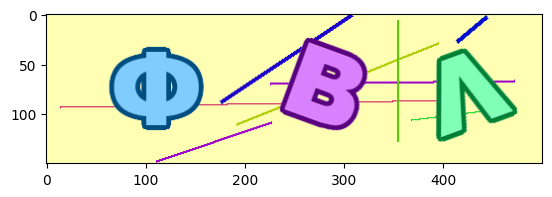

In [225]:
idx = np.random.randint(0, 2000)
path_ = DATA_PATH + file_paths[idx]
letters = umbrella_get_letters(path_)
img = cv2.imread(path_)
plt.imshow(img)

letters = np.array(letters)
letters = np.expand_dims(letters, -1)
# letter = np.expand_dims(letter, 0)
logits = model.predict(letters)
# classes[]
# logits
indices = np.argmax(logits, axis=1)
[classes[index] for index in indices]

In [226]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 13, 13, 7)         70        
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 7)          0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 252)               0         
                                                                 
 dense_11 (Dense)            (None, 24)                6072      
                                                                 
Total params: 6,142
Trainable params: 6,142
Non-trainable params: 0
_________________________________________________________________


In [227]:
model.save('./model.h5')